This notebook is a tutorial to show how to manage the preprocessed data for sleep stage classification

In [68]:
import numpy as np 
import gzip as gz 
from tqdm.notebook import tqdm
import torch as th 
import pickle
import matplotlib.pyplot as plt

In [69]:
datad = r'C:\Users\EstebanPapacitoRico\Documents\GitHub\DL_Project\sleep-edf-prepared\5-cassette'


In [70]:
fp = gz.open(datad+'/SC4671G0.npz.gz','rb')
data = np.load(fp,allow_pickle=True) 
class_dict = {0: "W", 1: "N1", 2: "N2", 3: "N3", 4: "REM", 5: "UNKNOWN"}

In [71]:
# To see what it contains 
data.files

['x', 'y', 'fs', 'ch_label', 'header_raw', 'header_annotation']

In [72]:
# The data are stored in 'x' and 'y'
x = data['x']
y = data['y']

In [73]:
print(x.shape, y.shape)

(1968, 600, 4) (1968,)


In [74]:
# The header is the copy of the original one 
print(data['header_raw'])


{'local_subject_id': 'X F X Female_87yr', 'local_recording_id': 'Startdate 07-AUG-1991 X X X', 'date_time': '2091-08-07 16:00:00', 'EDF+': False, 'contiguous': True, 'n_records': 2780, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag-AgCl electrodes', 'Rectal thermistor', 'Marker button'], 'units': ['uV', 'uV', 'uV', '', 'uV', '', ''], 'physical_min': array([ -207.,  -179., -1055., -2048.,    -5.,     0., -2047.]), 'physical_max': array([ 207.,  179., 1055., 2047.,    5.,   30., 2048.]), 'digital_min': array([ -2048.,  -2048.,  -2048.,  -2048.,  -2500., -32768.,  -2047.]), 'digital_max': array([ 2047.,  2047.,  2047.,  2047.,  2500., 32767.,  2048.]), 'prefiltering': ['HP:0.5Hz LP:100Hz [enhanced cassette BW]', 'HP:0.5Hz LP:100Hz [enhanced cassette BW]', 'HP:0.

In [75]:
print(data['header_annotation'])

{'local_subject_id': 'X F X Female_87yr', 'local_recording_id': 'Startdate 07-AUG-1991 X X X', 'date_time': '2091-08-07 16:00:00', 'EDF+': True, 'contiguous': True, 'n_records': 1, 'record_length': 0.0, 'n_channels': 1, 'label': ['EDF Annotations'], 'transducer_type': [''], 'units': [''], 'physical_min': array([0.]), 'physical_max': array([1.]), 'digital_min': array([-32768.]), 'digital_max': array([32767.]), 'prefiltering': [''], 'n_samples_per_record': [3062]}


In [76]:
# The four channels in x are 'EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental'
# You can take more if you modify the preparation script and rerun it. 
# To get a list all the files:
import os 
import glob
fnames = glob.glob(os.path.join(datad, "*npz.gz"))
print(fnames[:10]) # print the first 10

['C:\\Users\\EstebanPapacitoRico\\Documents\\GitHub\\DL_Project\\sleep-edf-prepared\\5-cassette\\SC4001E0.npz.gz', 'C:\\Users\\EstebanPapacitoRico\\Documents\\GitHub\\DL_Project\\sleep-edf-prepared\\5-cassette\\SC4002E0.npz.gz', 'C:\\Users\\EstebanPapacitoRico\\Documents\\GitHub\\DL_Project\\sleep-edf-prepared\\5-cassette\\SC4011E0.npz.gz', 'C:\\Users\\EstebanPapacitoRico\\Documents\\GitHub\\DL_Project\\sleep-edf-prepared\\5-cassette\\SC4012E0.npz.gz', 'C:\\Users\\EstebanPapacitoRico\\Documents\\GitHub\\DL_Project\\sleep-edf-prepared\\5-cassette\\SC4021E0.npz.gz', 'C:\\Users\\EstebanPapacitoRico\\Documents\\GitHub\\DL_Project\\sleep-edf-prepared\\5-cassette\\SC4022E0.npz.gz', 'C:\\Users\\EstebanPapacitoRico\\Documents\\GitHub\\DL_Project\\sleep-edf-prepared\\5-cassette\\SC4031E0.npz.gz', 'C:\\Users\\EstebanPapacitoRico\\Documents\\GitHub\\DL_Project\\sleep-edf-prepared\\5-cassette\\SC4032E0.npz.gz', 'C:\\Users\\EstebanPapacitoRico\\Documents\\GitHub\\DL_Project\\sleep-edf-prepared\\5-c

In [85]:
devpart = 10
xtrain , xvalid = None , None 
ytrain , yvalid = None , None 
# If you take all the data you dhould end with 
# 
for fn in tqdm(fnames): 
    fp = gz.open(fn,'rb')
    data = np.load(fp,allow_pickle=False) # for now, don't care about headers
    
    x = data['x'][:,:,1] # Take only the EOG
    y = data['y'] # Take the labels 
    
    idx = np.arange(x.shape[0]) # we create an index vector
    np.random.shuffle(idx) # we shuffle it
    devlim = x.shape[0]//devpart # we take 1/10 of the data for validation

    if xtrain is None: 
        xtrain = np.zeros((1,x.shape[1])) # we create the first dummy row of the matrix as example
        xvalid = np.zeros((1,x.shape[1]))
        ytrain , yvalid = np.zeros(1) , np.zeros(1)

    # we concatenate the data to create a whole time series
    # we use the index to shuffle the data (we lose the time sequence correlation)
    xvalid = np.concatenate((xvalid,x[idx[:devlim]]), axis=0)
    yvalid = np.concatenate((yvalid,y[idx[:devlim]]), axis=0) 
    xtrain = np.concatenate((xtrain,x[idx[devlim:]]), axis=0) 
    ytrain = np.concatenate((ytrain,y[idx[devlim:]]), axis=0) 
    del x,y

  0%|          | 0/153 [00:00<?, ?it/s]

In [86]:
print(xtrain.shape, xvalid.shape)
print(ytrain.shape, yvalid.shape)


(175996, 600) (19485, 600)
(175996,) (19485,)


In [87]:
# clean the first dummy example 
xtrain , xvalid = xtrain[1:] , xvalid[1:] 
ytrain , yvalid = ytrain[1:] , yvalid[1:] 
print(xtrain.shape, xvalid.shape)
print(ytrain.shape, yvalid.shape)


(175995, 600) (19484, 600)
(175995,) (19484,)


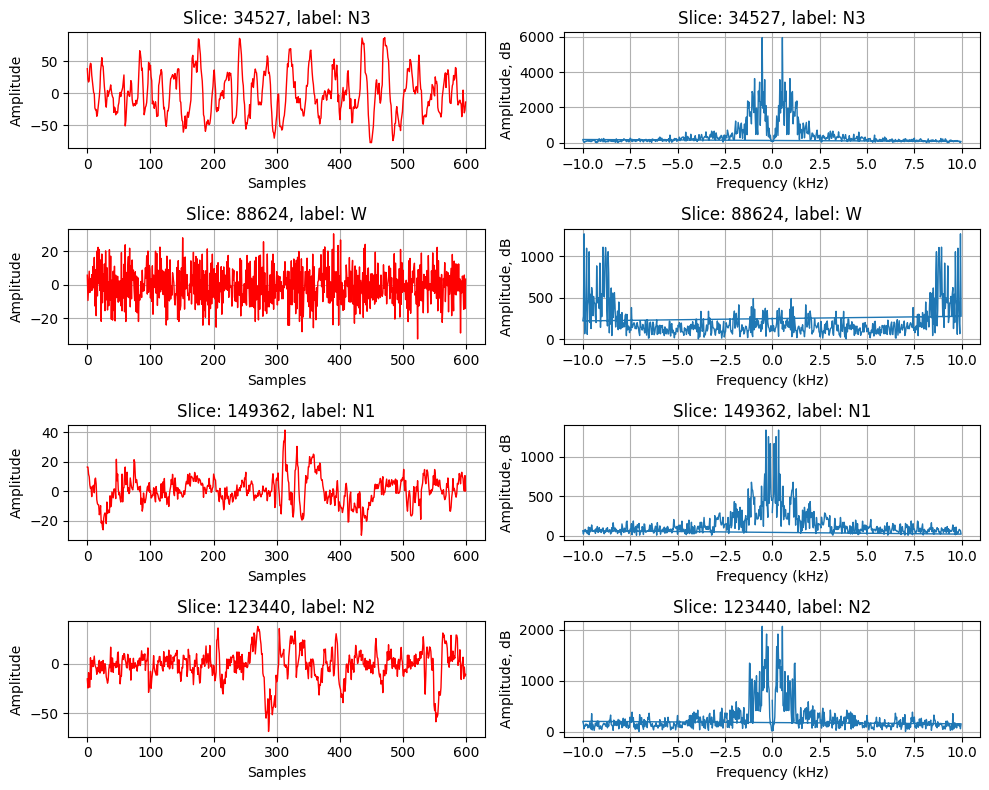

In [90]:
# Select 4 random rows from xtrain
n_row = 4
rows = np.random.choice(xtrain.shape[0], n_row, replace=False)

# Create a 2x2 tiled layout
fig, axs = plt.subplots(n_row, 2, figsize=(10, 8))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each selected row
for i, row in enumerate(rows):
    axs[2*i].plot(xtrain[row], 'r', linewidth=1)
    axs[2*i].set_title(f'Slice: {row}, label: {class_dict[ytrain[row]]}')
    axs[2*i].set_xlabel('Samples')
    axs[2*i].set_ylabel('Amplitude')
    axs[2*i].grid(True)

    sfreq = 20  # 20kHz

    # Compute Fourier Transform
    fourier_transform = np.fft.fft(xtrain[row])
    frequencies = np.fft.fftfreq(len(xtrain[row]), d=1./sfreq)  # Correct the frequencies using the sampling interval
    fourier_transform_dB = 20*np.log10(np.abs(fourier_transform/np.max(fourier_transform)))
    fourier_transform_abs = np.abs(fourier_transform)

    axs[2*i+1].plot(frequencies, fourier_transform_abs, linewidth=1)
    axs[2*i+1].set_title(f'Slice: {row}, label: {class_dict[ytrain[row]]}')
    axs[2*i+1].set_xlabel('Frequency (kHz)')
    axs[2*i+1].set_ylabel('Amplitude, dB')
    axs[2*i+1].grid(True)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [81]:
# In Torch version 
xtrain, xvalid = th.FloatTensor(xtrain), th.FloatTensor(xvalid)
ytrain, yvalid = th.IntTensor(ytrain), th.IntTensor(yvalid)

In [82]:
outf="./sleep-edf-prepared/EEG-Pz-cassette-th-data.pck"
fp = open(outf,"wb")
pickle.dump((xtrain , xvalid , ytrain , yvalid), fp)

In [83]:
print("xtrain:")
print(xtrain[:2])

print("ytrain:")
print(ytrain[:2])


xtrain:
tensor([[ 0.1407, -3.4227, 17.3011,  ..., 16.7385,  8.6740, -0.8908],
        [ 7.0799, 15.6132, 17.1136,  ..., -3.4227,  5.4857,  5.8608]])
ytrain:
tensor([4, 4], dtype=torch.int32)
